In [154]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inspect

# 距离 vs 对比度

In [155]:
vis_df = pd.read_csv('vis_ion.csv')
_parity_index=(vis_df['parity']>0)
_visbility_index=(vis_df['distance']>0)

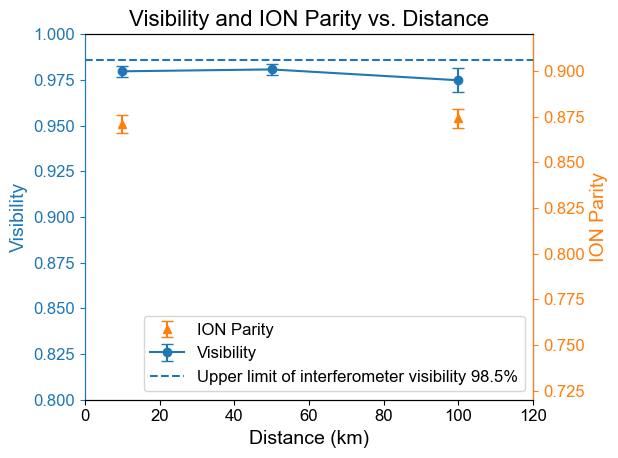

In [156]:
VIS_HIGHLINE=0.9861
VISHIGHLINE_ERR=0.0137
fig,ax1=plt.subplots()
ax2=ax1.twinx()

# 绘制数据并保存返回值以获取句柄
vis_line = ax1.errorbar(vis_df['distance'][_visbility_index],vis_df['visibility'][_visbility_index],fmt='o-',yerr=vis_df['vis_err'][_visbility_index],capsize=4,label='Visibility')
ion_line = ax2.errorbar(vis_df['distance'][_parity_index],vis_df['parity'][_parity_index],fmt='^',color='C1',yerr=vis_df['parity_err'][_parity_index],capsize=4,label='ION Parity')
limit_line = ax1.axhline(VIS_HIGHLINE,ls='--',color='C0',label='Upper limit of interferometer visibility 98.5%')

# 设置轴的颜色
ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')
ax1.spines['left'].set_color('C0')
ax2.spines['left'].set_color('C0')
ax2.spines['right'].set_color('C1')

# 设置轴标签和范围
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Visibility',color='C0')
ax1.set_ylim(0.8,1)
ax2.set_ylabel('ION Parity',color='C1')
ax2.set_ylim(0.72,0.92)
# 合并所有图例
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines = [h for handles, labels in lines_labels for h in handles]
labels = [l for handles, labels in lines_labels for l in labels]
ax1.legend(lines[::-1], labels[::-1],loc='lower right')  # 可以根据需要调整位置

# 添加标题使图表更完整
plt.xlim(0,120)
plt.title('Visibility and ION Parity vs. Distance')
plt.tight_layout()
plt.show()

## 对比度拟合

In [157]:

from scipy.optimize import curve_fit

import inspect
def count2gamma(df):
    """
    该函数用于将 PMT 计数数据转换为 gamma 值、gamma 误差和相位值。

    参数:
    df (pandas.DataFrame): 包含 PMT 计数数据的 DataFrame，应包含 'pmt1'、'pmt2' 和 'turn' 列。

    返回:
    pandas.DataFrame: 包含计算后的 'gamma'、'gamma_err' 和 'phase' 列的 DataFrame。
    """
    # 计算 gamma 值，公式为 (pmt1 - pmt2) / (pmt1 + pmt2)
    df['gamma']=(df['pmt1']-df['pmt2'])/(df['pmt1']+df['pmt2'])
    # 计算 gamma 误差的平方，公式为 (2 * pmt2 / ((pmt1 + pmt2) ** 2) * sqrt(pmt1)) ** 2 + (-2 * pmt1 / ((pmt1 + pmt2) ** 2) * sqrt(pmt2)) ** 2
    df['gamma_err']=(2*df['pmt2']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt1']))**2+(-2*df['pmt1']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt2']))**2
    # 对 gamma 误差的平方取平方根，得到 gamma 误差
    df['gamma_err']=np.sqrt(df['gamma_err'])
    # 计算相位值，公式为 turn * 360 * 2
    df['phase']=df['turn']*360*2
# 定义模型函数：正弦波
def model_func_count_offset(x, gamma, phase_offset,count_offset):
    """
    A sin(x + phi) + B
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))+count_offset

def model_func_sin(x, gamma, phase_offset):
    """
    A sin(x + phi)
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))



# 生成数据点
def estimate_gamma(df,model_func=model_func_count_offset):
    """  A cos(df + B)
    return estimate [A,B]"""
    x_data = df['turn']*360*2  # x轴数据
    y_data = df['gamma']  # y轴数据
    y_err = df['gamma_err']  # y轴数据误差
    pmt1 = df['pmt1']
    pmt2 = df['pmt2']
    x_data_arange = np.linspace(0, 360*2, 200)  # 生成更多数据点用于拟合
    # 使用curve_fit进行非线性最小二乘法拟合
    # 定义参数的下界和上界
    # 获取函数的参数信息
    sig = inspect.signature(model_func)
    # 获取参数的数量
    param_count = len(sig.parameters)
    if param_count == 2+1:
        lower_bounds = [0, 0]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    elif param_count == 3+1:
        lower_bounds = [0, 0,-0.1]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi,0.2]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    else:
        print('model_func has {} parameters, but only 2 or 3 parameters are supported'.format(param_count))
        params, covariance = curve_fit(model_func, x_data, y_data,sigma=y_err)

    # 使用拟合参数计算预测值
    y_pred = model_func(x_data, *params)

    # 计算R²
    mean_y = np.mean(y_data)
    total_variance = np.sum((y_data - mean_y) ** 2)
    residual_variance = np.sum((y_data - y_pred) ** 2)
    r_squared = 1 - (residual_variance / total_variance)
    # 输出拟合参数
    if param_count == 2+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, R²={r_squared:.3%}")
    elif param_count == 3+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, count_offset={params[2]:.3f}±{np.sqrt(np.diag(covariance))[2]:.3f}, R²={r_squared:.3%}")

    # 绘制原始数据点和拟合曲线
    plt.subplot(211)
    plt.errorbar(x_data,pmt1,fmt='-o',yerr=np.sqrt(pmt1),label='pmt1',capsize=5)
    plt.errorbar(x_data,pmt2,fmt='-o',yerr=np.sqrt(pmt2),label='pmt2',capsize=5)
    plt.plot(x_data,(pmt1+pmt2)/2, 'x-.', label='(pmt1+pmt2)/2')
    plt.xlim(0,360*2)
    plt.xlabel('phase offset with 729 OAM turn [°]')
    plt.ylabel('pmt counts')
    plt.title('PMT count, experimental error estimate by shot noise')
    plt.legend(loc=1)
    plt.grid()
    plt.subplot(212)
    plt.errorbar(x_data, (y_data), fmt='o', label='experimental data',yerr=y_err,capsize=5)
    plt.plot(x_data_arange,(model_func(x_data_arange, *params)), '-', label='fit {:.1%}±{:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0]))
    plt.xlabel('phase offset with 729 OAM turn [°] {:+.2f}°'.format(params[1]/np.pi*180))
    plt.ylabel('estimae gamma')
    plt.title('LS estimae $\\gamma$: {:.3%}±{:.3%}, $R^2=${:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0],r_squared))
    plt.xlim(0,360*2)
    plt.legend(loc=1)
    plt.grid()
    plt.tight_layout()
    params_err=np.sqrt(np.diag(covariance))

    return params,params_err


-------------origin data-----------------
Fitted parameters: gamma=0.981±0.003, phase_offset=3.144±0.012, count_offset=-0.003±0.003, R²=99.980%


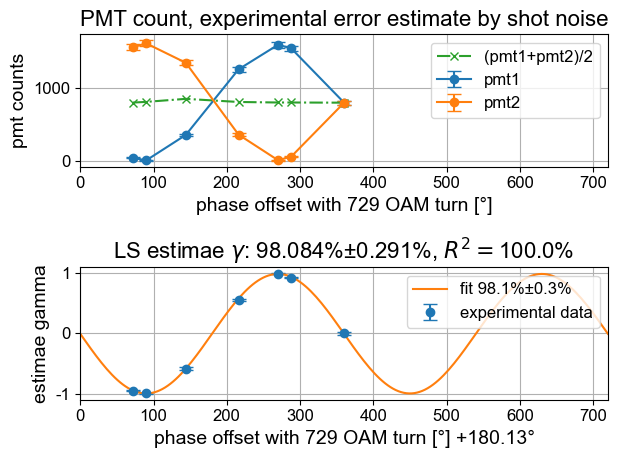

In [158]:
out_csv='50km/gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
monitor_df=res_data[res_data['state']=='monitor']
print('-------------origin data-----------------')
param_origin,param_origin_err=estimate_gamma(origin_df,model_func=model_func_count_offset)
plt.show()

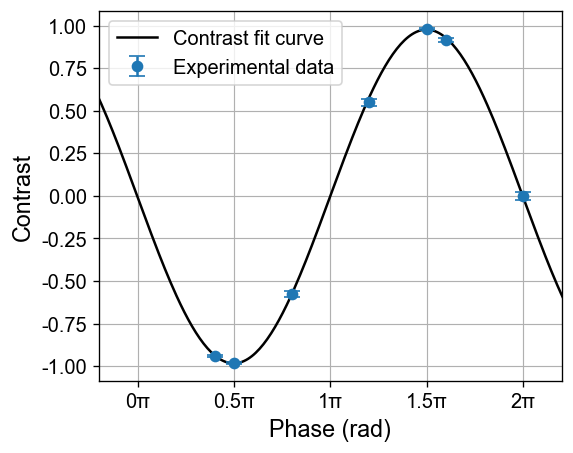

In [159]:
phase_array=np.linspace(-180,360*2,500)
turn_array=phase_array/360/2
origin_fit=model_func_count_offset(phase_array,*param_origin)

plt.figure(figsize=(5,4),dpi=120)
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.labelsize': 14,     # 坐标轴标签字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'legend.fontsize': 12,    # 图例字体大小
    'xtick.labelsize': 12,    # x轴刻度标签字体大小
    'ytick.labelsize': 12     # y轴刻度标签字体大小
})
plt.plot(turn_array*4,origin_fit,label='Contrast fit curve',color='k')
plt.errorbar(origin_df['turn']*4,origin_df['gamma'],yerr=origin_df['gamma_err'],fmt='o',capsize=5,
             label='Experimental data',color='C0')
plt.legend()
plt.xlabel('Phase (rad)')
plt.xlim(-0.2,2+0.2)
# 设置x轴刻度为π的倍数并添加π符号
ticks = np.arange(0, 2+0.2, 1/2)
labels = ['0π', '0.5π', '1π', '1.5π', '2π']
plt.xticks(ticks, labels)
plt.ylabel('Contrast (100%)')
plt.ylabel('Contrast')
plt.grid(which='major', linewidth=0.7)  # 主刻度网格线（较粗）
plt.tight_layout()
# plt.savefig('fig_sm_5b.jpeg',dpi=300)
plt.show()

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_98748/1350374585.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


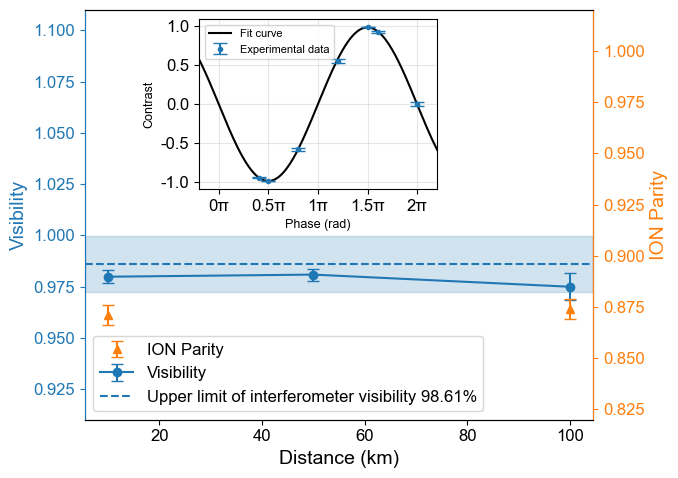

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches
VIS_HIGHLINE=0.9861
VISHIGHLINE_ERR=0.0137

# 4. 创建图表
fig, ax1 = plt.subplots(figsize=(7,5),dpi=100)
ax2=ax1.twinx()

# 绘制数据并保存返回值以获取句柄
vis_line = ax1.errorbar(vis_df['distance'][_visbility_index],vis_df['visibility'][_visbility_index],fmt='o-',yerr=vis_df['vis_err'][_visbility_index],capsize=4,label='Visibility')
ion_line = ax2.errorbar(vis_df['distance'][_parity_index],vis_df['parity'][_parity_index],fmt='^',color='C1',yerr=vis_df['parity_err'][_parity_index],capsize=4,label='ION Parity')
## 绘制上限区域
## 绘制上限区域
limit_line = ax1.axhline(VIS_HIGHLINE,ls='--',color='C0',label='Upper limit of interferometer visibility {:.2%}'.format(VIS_HIGHLINE))
limit_line_err = ax1.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color='C0', alpha=0.2)

# 设置轴的颜色
ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')
ax1.spines['left'].set_color('C0')
ax2.spines['left'].set_color('C0')
ax2.spines['right'].set_color('C1')

# 设置轴标签和范围
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Visibility',color='C0')
ax1.set_ylim(0.9+0.01,1.1+0.01)
ax2.set_ylabel('XX ',color='C1')
ax2.set_ylim(0.73+0.09,0.93+0.09)
# 合并所有图例
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines = [h for handles, labels in lines_labels for h in handles]
labels = [l for handles, labels in lines_labels for l in labels]
ax1.legend(lines[::-1], labels[::-1],loc='lower left')  # 可以根据需要调整位置

# 5. 创建嵌入图（副图）
ax_inset = fig.add_axes([0.3, 0.6, 0.34, 0.34])  # [left, bottom, width, height]

# 绘制副图：时间符合直方图
ax_inset.plot(turn_array*4,origin_fit,label='Fit curve',color='k')
ax_inset.errorbar(origin_df['turn']*4,origin_df['gamma'],yerr=origin_df['gamma_err'],fmt='.',capsize=5,
             label='Experimental data',color='C0')

# 设置副图坐标轴（对数纵坐标）
ax_inset.set_xlabel(' (ns)', fontsize=9)
ax_inset.set_ylabel('', fontsize=9)
ax_inset.legend(fontsize=8)
ax_inset.grid(True, alpha=0.3)
ax_inset.set_xlabel('Phase (rad)', fontsize=9)
ax_inset.set_xlim(-0.2,2+0.2)
# 设置x轴刻度为π的倍数并添加π符号
ticks = np.arange(0, 2+0.2, 1/2)
labels = ['0π', '0.5π', '1π', '1.5π', '2π']
ax_inset.set_xticks(ticks)
ax_inset.set_xticklabels(labels)
ax_inset.set_ylabel('Contrast')
# 6. 美化图表
plt.tight_layout()
plt.show()

# 7. 可选：保存图表
# plt.savefig('quantum_interference_plot.png', dpi=300, bbox_inches='tight')